In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import boxcox

from imp import load_source

from sklearn.decomposition import PCA

import aggregate_player_stats as aps

query_strings = load_source('query_strings', '../stats_generation/query_strings.py' )
gps = load_source(  'generate_player_stats', '../stats_generation/generate_player_stats.py' )

In [2]:
%matplotlib inline
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

Generate stuff for whole team

In [3]:
reload(aps)
team_stats_df = aps.generate_full_team_aggregate( 2017, drop_preseason=False )

In [4]:
print team_stats_df.shape
print team_stats_df.columns.values

(5132, 71)
[u'team' 'opp_team' u'week' 'year' 'score' 'opp_score' 'home_flag'
 'away_flag' 'tds' u'rush_att' u'rush_yds' u'pass_att' u'pass_yds'
 u'pass_cmp' u'pass_sack' u'kickoffs' u'punts' u'fg_miss' u'kickret_tds'
 u'punt_ret_tds' u'off_fumb_tot' u'kickoff_in_20' u'kickoff_touchback'
 u'fg_yds' u'fg_made' u'def_int_tds' u'def_frec_tds' u'def_misc_tds'
 u'def_safety' u'def_tkl' u'def_tkl_contributers' u'def_fumb_rec'
 u'def_fumb_forced' u'def_int' u'def_tkl_loss' u'def_sack' u'def_pass_def'
 'score_prev_4' 'opp_score_prev_4' 'home_flag_prev_4' 'away_flag_prev_4'
 'tds_prev_4' 'rush_att_prev_4' 'rush_yds_prev_4' 'pass_att_prev_4'
 'pass_yds_prev_4' 'pass_cmp_prev_4' 'pass_sack_prev_4' 'kickoffs_prev_4'
 'punts_prev_4' 'fg_miss_prev_4' 'kickret_tds_prev_4' 'punt_ret_tds_prev_4'
 'off_fumb_tot_prev_4' 'kickoff_in_20_prev_4' 'kickoff_touchback_prev_4'
 'fg_yds_prev_4' 'fg_made_prev_4' 'def_int_tds_prev_4'
 'def_frec_tds_prev_4' 'def_misc_tds_prev_4' 'def_safety_prev_4'
 'def_tkl_prev_4'

Defense needs to focus on defensive stats, and some small offensive stats from previous opponents

In [4]:
off_stats = [
                'tds',           # May be useful to keep
                u'rush_att', 
                u'rush_yds',     # May be useful
                u'pass_att', 
                u'pass_yds',     # May be useful
                u'pass_cmp', 
                u'pass_sack', 
                u'kickoffs',
                u'punts', 
                u'fg_miss', 
                u'off_fumb_tot',
                u'kickoff_in_20', 
                u'kickoff_touchback', 
                u'fg_yds', 
                u'fg_made' ]     # May be useful

keep_list = ['team','week','year','opp_team','tds','rush_yds','pass_yds','fg_made']

def_df = team_stats_df[ keep_list ].copy()

In [5]:
# def_frec?
def_stats = [
                u'def_int_tds',          # all_def_tds
                u'def_frec_tds',         # all_def_tds
                u'def_misc_tds' ,        # all_def_tds
                u'def_safety' ,          # def_safety
                u'def_tkl',
                u'def_tkl_contributers', 
                u'def_fumb_forced',
                u'def_fumb_rec',         # all_def_turn
                u'def_int' ,             # all_def_turn
                u'def_tkl_loss',
                u'def_sack' ,            # def_sack
                u'def_pass_def',
                u'kickret_tds',          # all_def_tds
                u'punt_ret_tds'          # all_def_tds
            ]


# All scored the same, hard to predict but can be useful en bulk
def_df['all_def_tds'] = team_stats_df[[
                                        'def_int_tds',
                                        'def_frec_tds',
                                        'def_misc_tds',
                                        'kickret_tds',
                                        'punt_ret_tds'
                                      ]].sum(axis=1)

def_df['all_def_turn'] = team_stats_df[[
                                        'def_fumb_rec',
                                        'def_int'
                                       ]].sum(axis=1)
def_df['def_safety'] = team_stats_df['def_safety']
def_df['def_sack'  ] = team_stats_df['def_sack'  ]

In [6]:
# Aggregate offensive stats are useful, for turning into OPPOSING stats
off_stats2 = [
                'score_prev_4' ,     # opp_
                'opp_score_prev_4' , # def_
                'home_flag_prev_4' , # def_
                'away_flag_prev_4',  # def_
                'tds_prev_4' ,       # opp_
                'rush_att_prev_4' ,
                'rush_yds_prev_4' ,  # opp_
                'pass_att_prev_4',
                'pass_yds_prev_4' ,  # opp_
                'pass_cmp_prev_4' ,
                'pass_sack_prev_4',  # def_
                'kickoffs_prev_4',
                'punts_prev_4' ,
                'fg_miss_prev_4' ,
                'off_fumb_tot_prev_4' ,
                'kickoff_in_20_prev_4' ,
                'kickoff_touchback_prev_4',
                'fg_yds_prev_4' ,
                'fg_made_prev_4'    # opp_
             ]


def_agg = ['opp_score_prev_4','home_flag_prev_4','away_flag_prev_4','pass_sack_prev_4']
opp_agg = ['score_prev_4','tds_prev_4','rush_yds_prev_4','pass_yds_prev_4','fg_made_prev_4']

def_df[def_agg] = team_stats_df[def_agg].copy()
def_df['allowed_points_prev_4'] = def_df['opp_score_prev_4']
def_df = def_df.drop( 'opp_score_prev_4', axis=1 )

a=[
u'prev_opp_score_prev_4',      
u'prev_opp_tds_prev_4',
u'prev_opp_rush_yds_prev_4', 
u'prev_opp_pass_yds_prev_4',
u'prev_opp_fg_made_prev_4',

u'allowed_score_prev_4',
u'allowed_tds_prev_4',  
u'allowed_rush_yds_prev_4',
u'allowed_pass_yds_prev_4',   
u'allowed_fg_made_prev_4',
]

def_df[opp_agg] = team_stats_df[opp_agg].copy()
def_df.rename(columns=dict(zip( opp_agg, ['allowed_'+x for x in opp_agg] )), inplace=True)

In [7]:
# Aggregate is good indicator for team
def_stats2 = [
                'kickret_tds_prev_4', 
                'punt_ret_tds_prev_4',
                'def_int_tds_prev_4',
                'def_frec_tds_prev_4', 
                'def_misc_tds_prev_4', 
                'def_safety_prev_4',
                'def_tkl_prev_4', 
                'def_tkl_contributers_prev_4', 
                'def_fumb_rec_prev_4',
                'def_fumb_forced_prev_4', 
                'def_int_prev_4', 
                'def_tkl_loss_prev_4',
                'def_sack_prev_4', 
                'def_pass_def_prev_4', 
                'includes_preseason'    
             ]

# All scored the same, hard to predict but can be useful en bulk
def_df['all_def_tds_prev_4'] = team_stats_df[[
                                        'def_int_tds_prev_4',
                                        'def_frec_tds_prev_4',
                                        'def_misc_tds_prev_4',
                                        'kickret_tds_prev_4',
                                        'punt_ret_tds_prev_4'
                                      ]].sum(axis=1)

def_df['all_def_turn_prev_4'] = team_stats_df[[
                                        'def_fumb_rec_prev_4',
                                        'def_int_prev_4'
                                       ]].sum(axis=1)
def_df['def_safety_prev_4'] = team_stats_df['def_safety_prev_4']
def_df['def_sack_prev_4'  ] = team_stats_df['def_sack_prev_4'  ]

In [33]:
def_df.head()

,team,week,year,opp_team,tds,rush_yds,pass_yds,fg_made,all_def_tds,all_def_turn,...,allowed_points_prev_4,allowed_score_prev_4,allowed_tds_prev_4,allowed_rush_yds_prev_4,allowed_pass_yds_prev_4,allowed_fg_made_prev_4,all_def_tds_prev_4,all_def_turn_prev_4,def_safety_prev_4,def_sack_prev_4
0,ARI,-3,2009,PIT,1,70,281,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,ARI,-2,2009,SD,0,64,233,2,0,0,...,20.0,10.0,1.0,70.0,281.0,1.0,0.0,0.0,0.0,0.0
2,ARI,-1,2009,GB,5,108,499,1,0,0,...,37.0,16.0,1.0,134.0,514.0,3.0,0.0,0.0,0.0,5.0
3,ARI,0,2009,DEN,0,68,193,0,0,1,...,81.0,53.0,6.0,242.0,1013.0,4.0,0.0,0.0,0.0,7.0
4,ATL,-3,2009,DET,3,113,115,2,1,1,...,111.0,142.0,18.0,469.0,1010.0,6.0,2.0,8.0,0.0,16.0


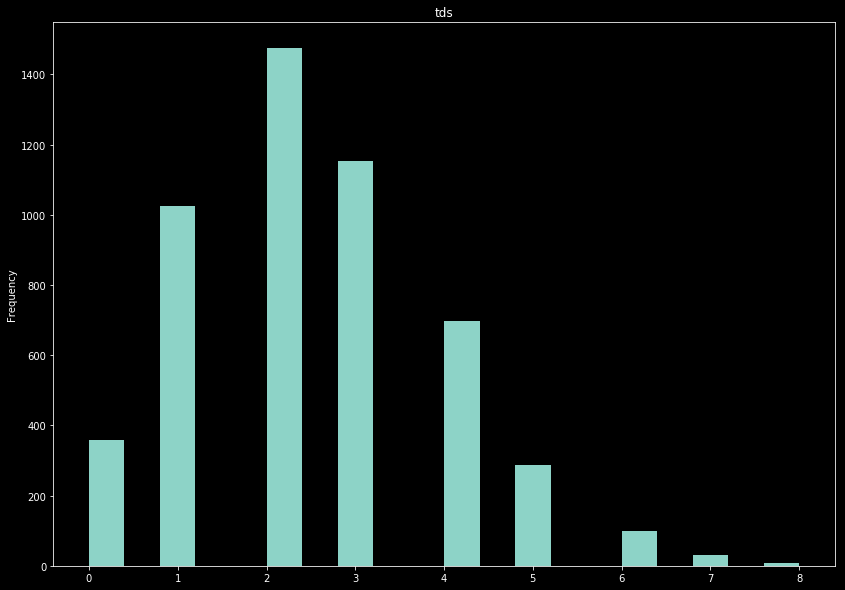

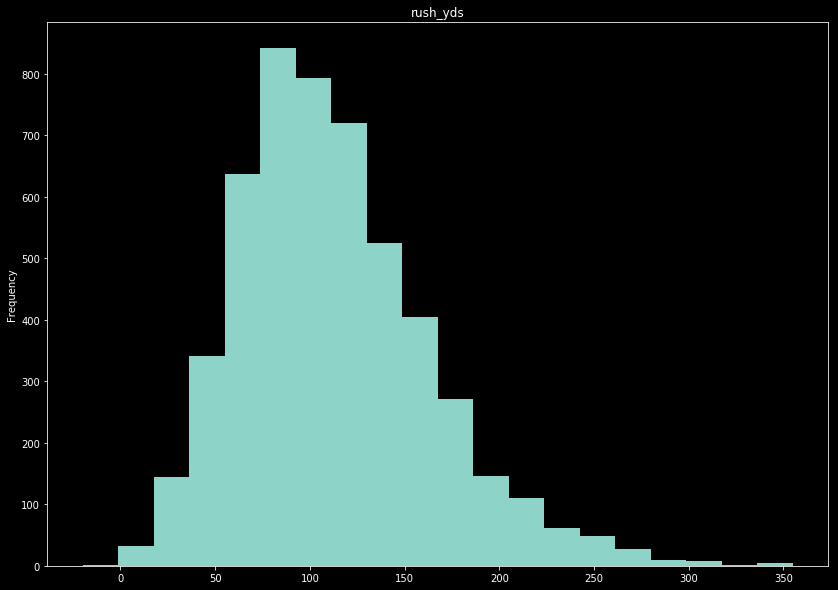

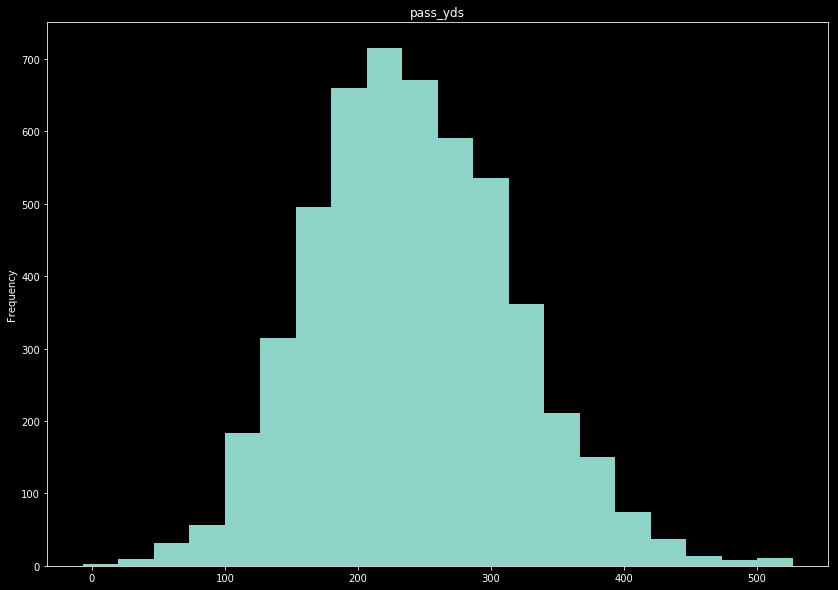

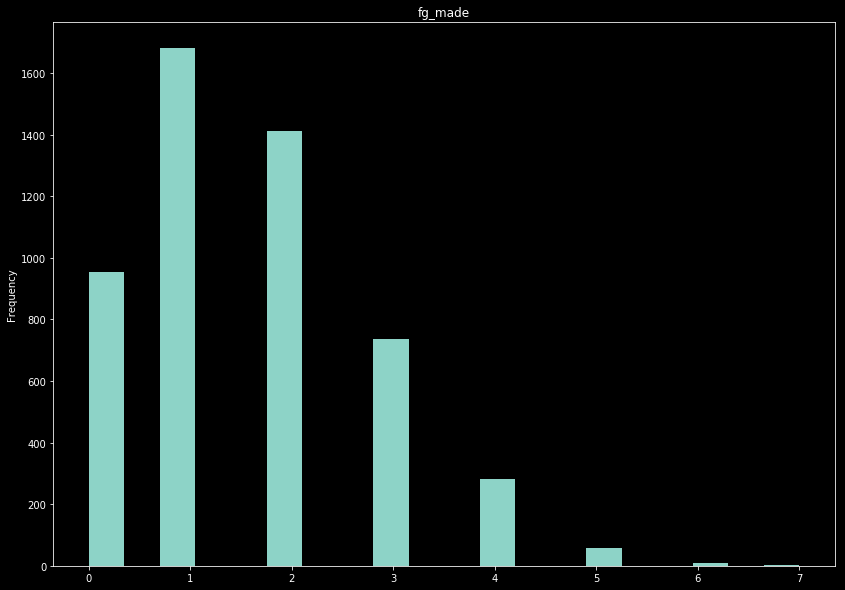

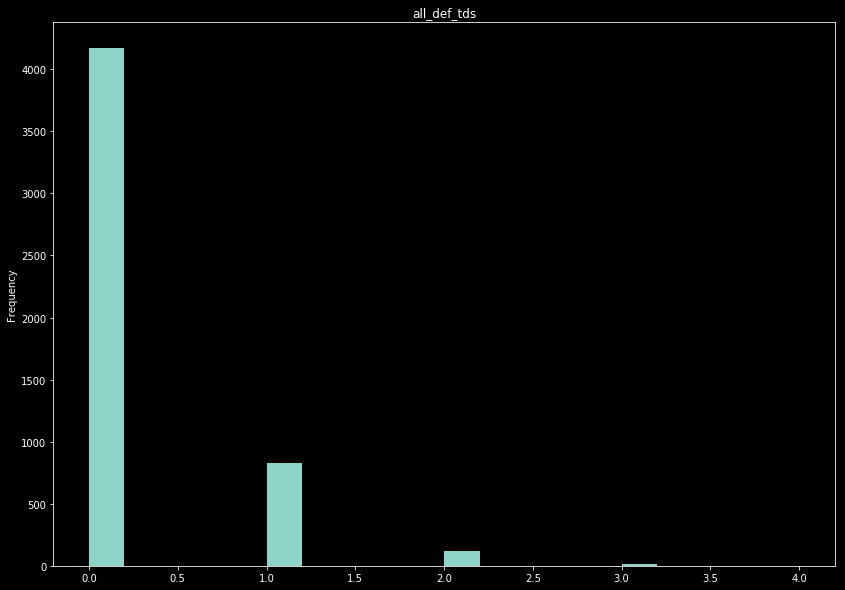

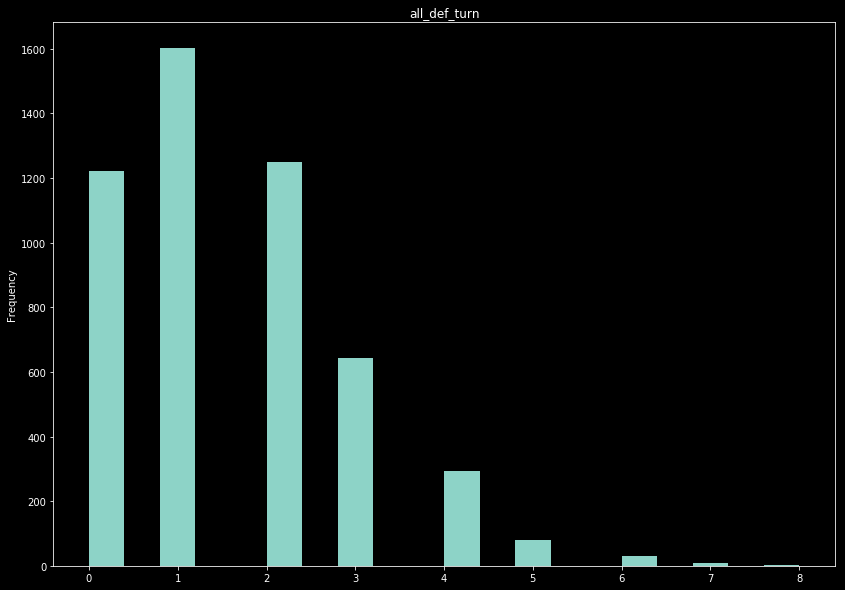

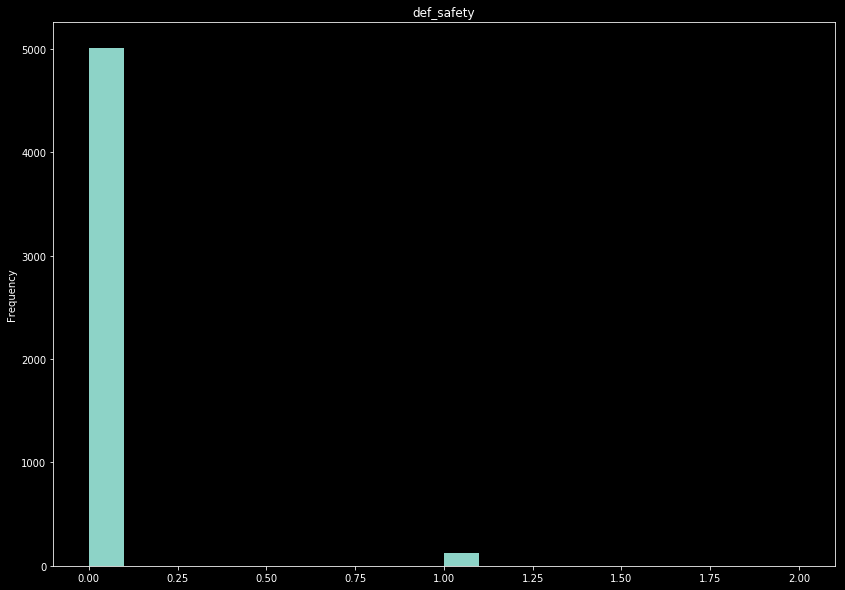

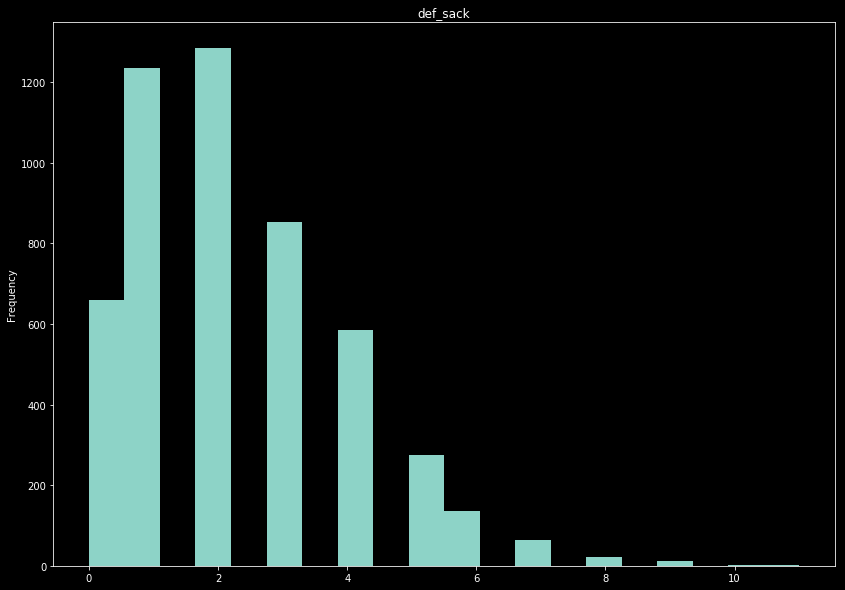

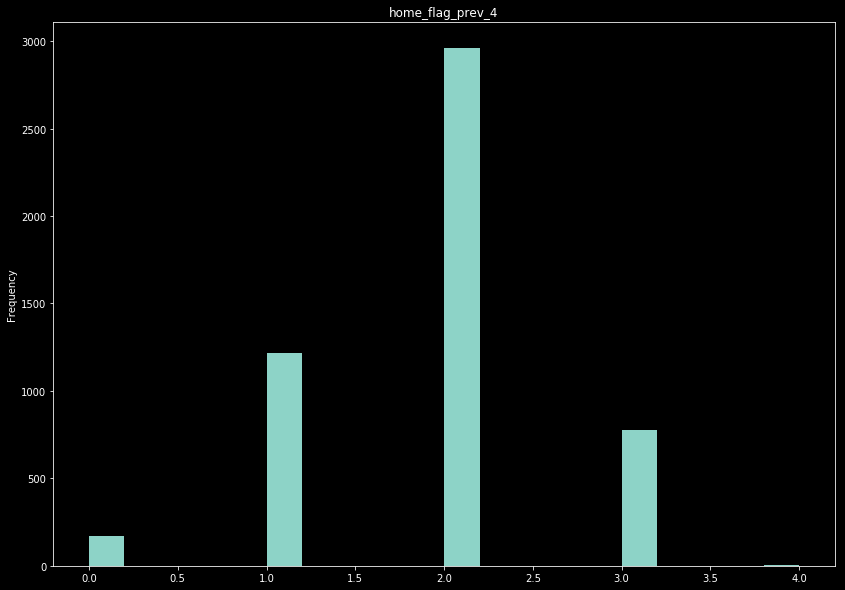

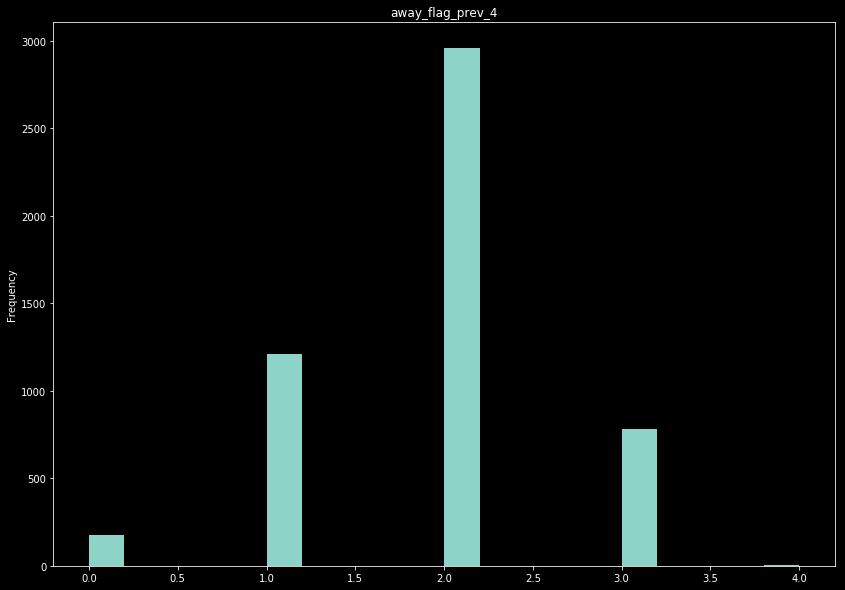

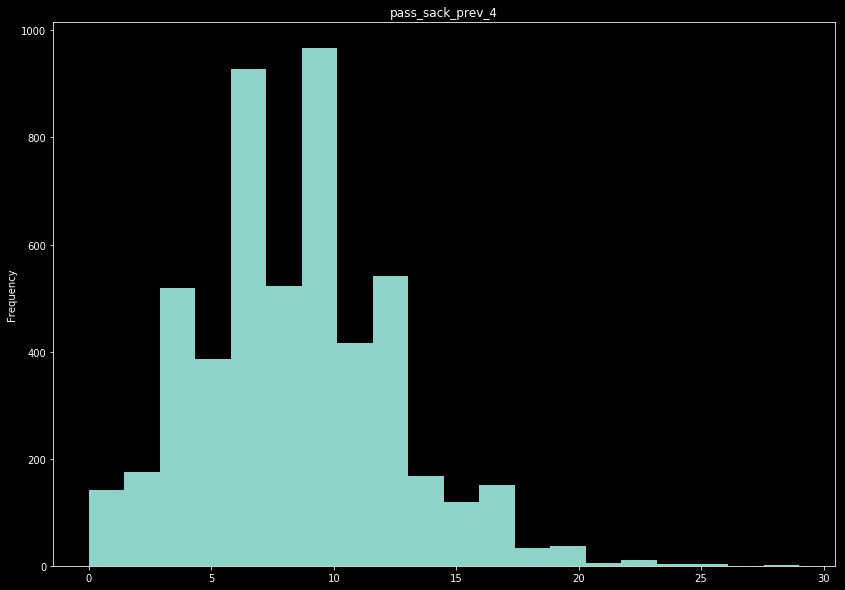

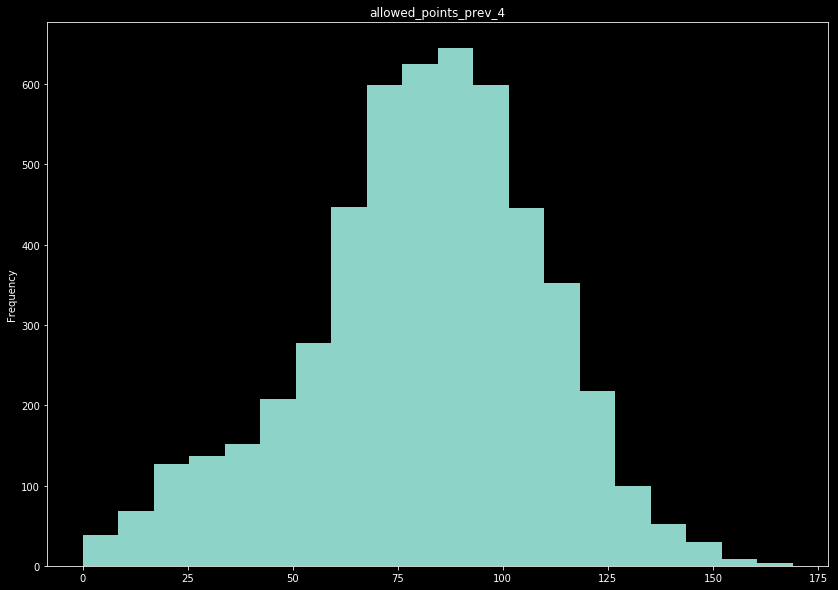

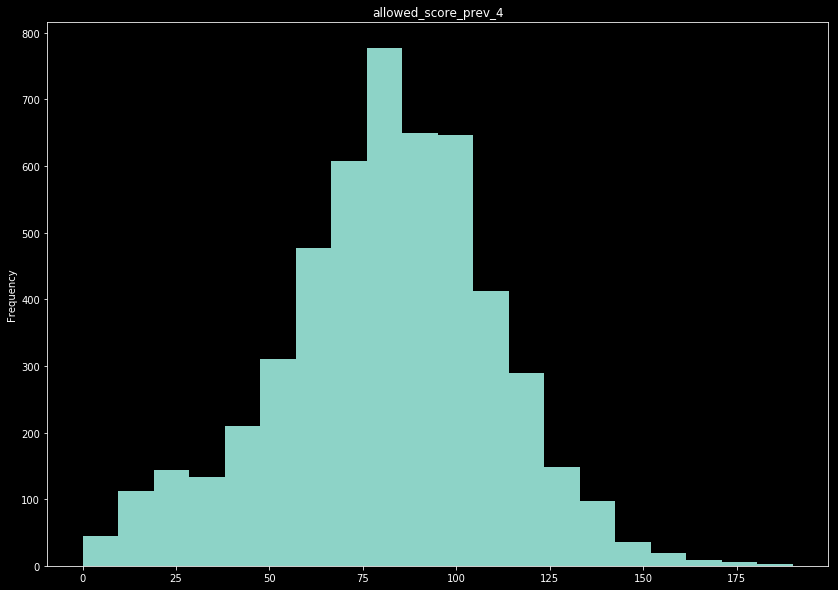

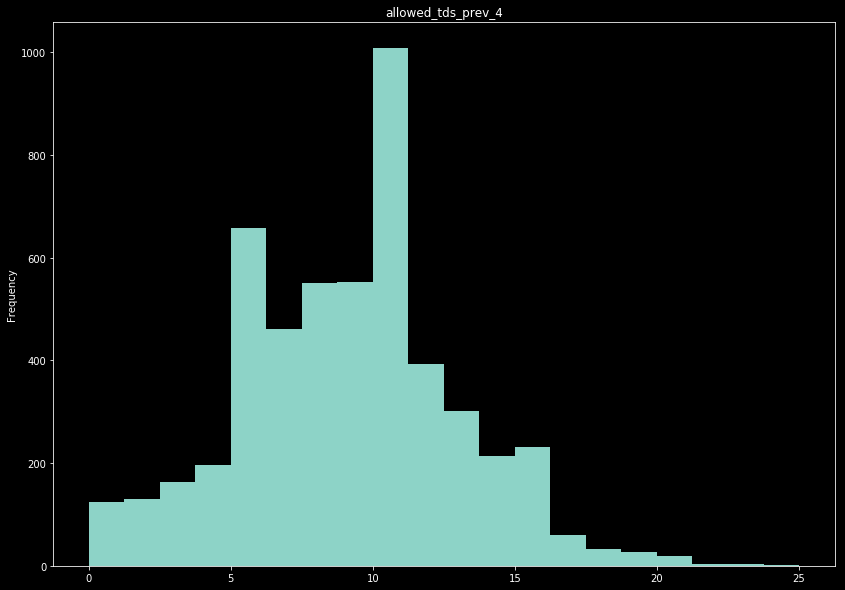

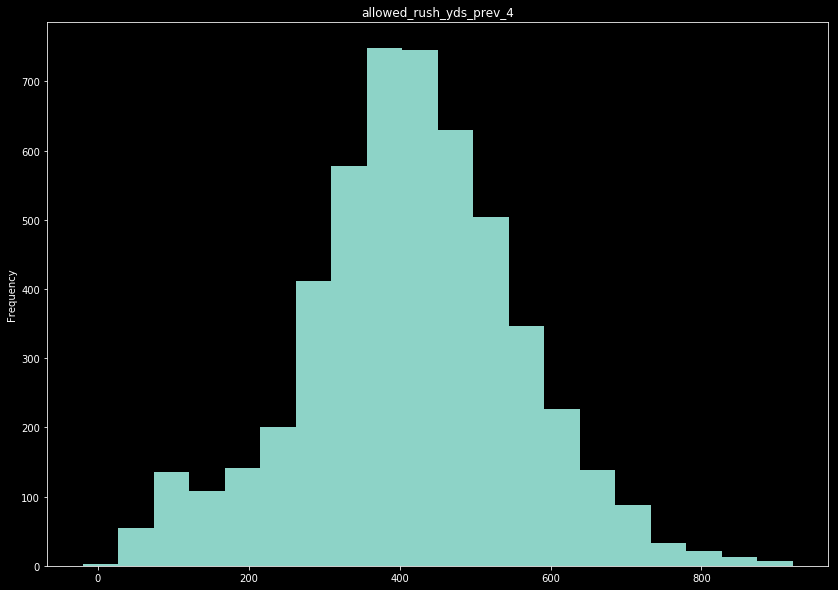

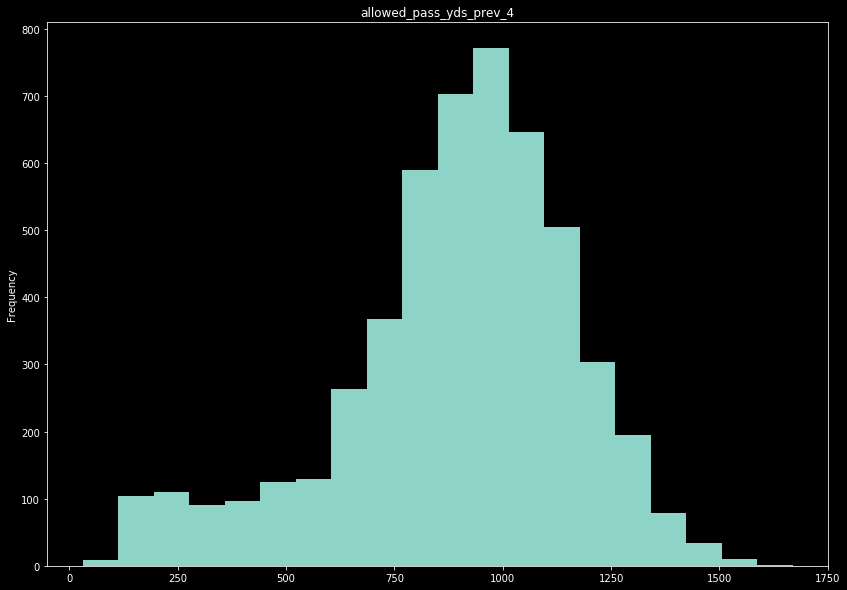

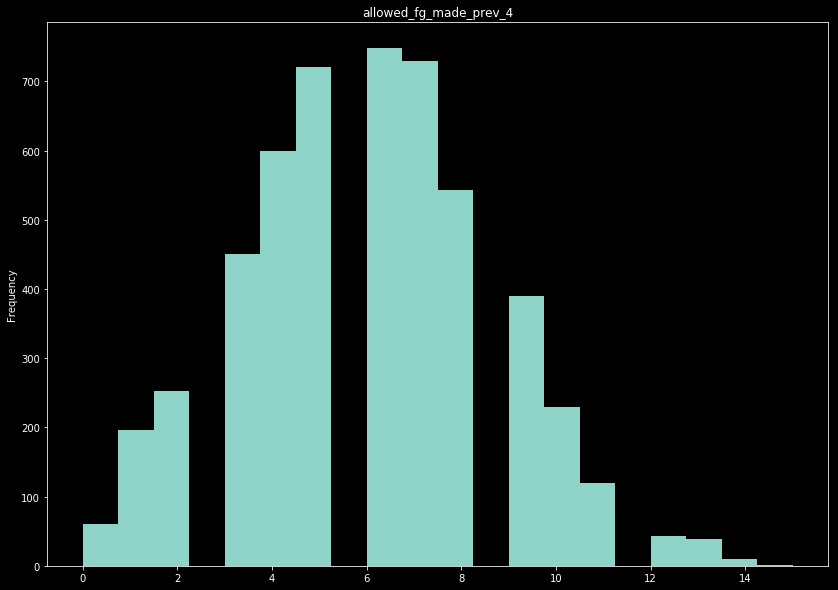

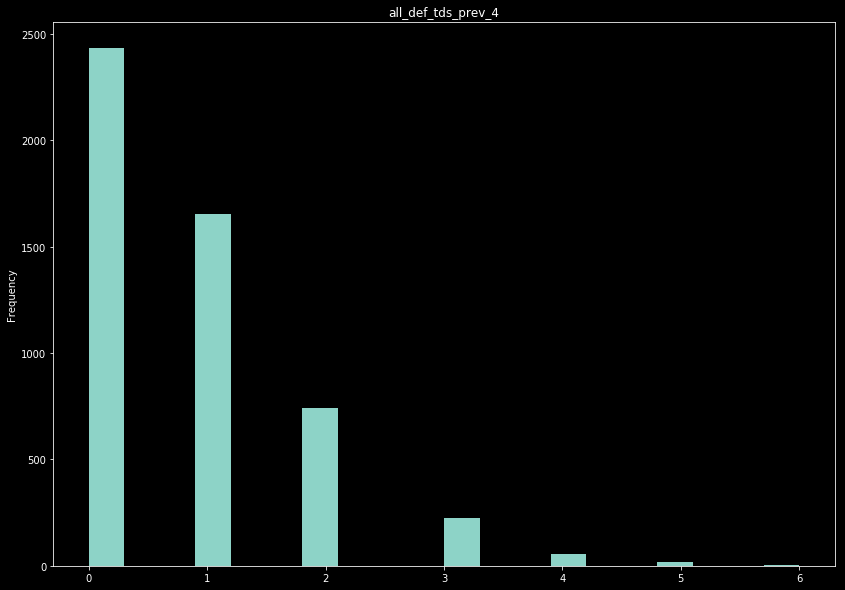

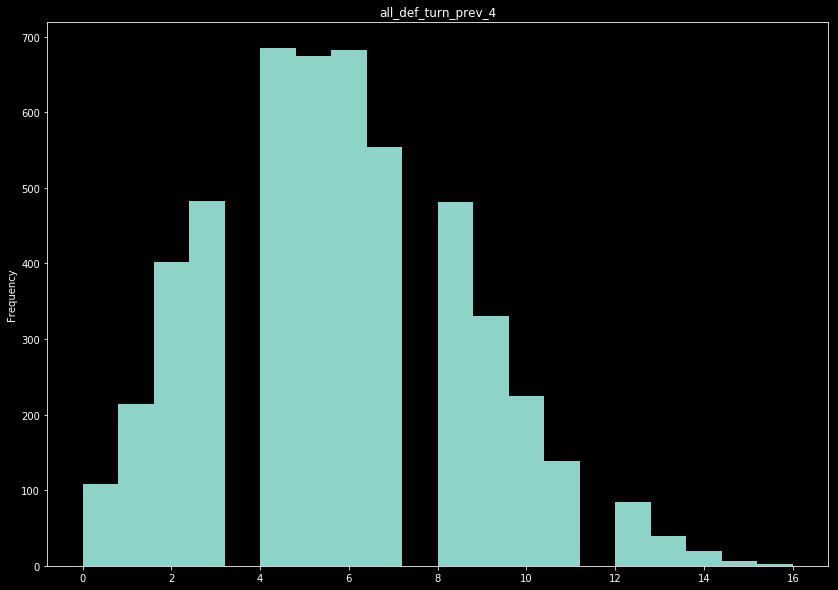

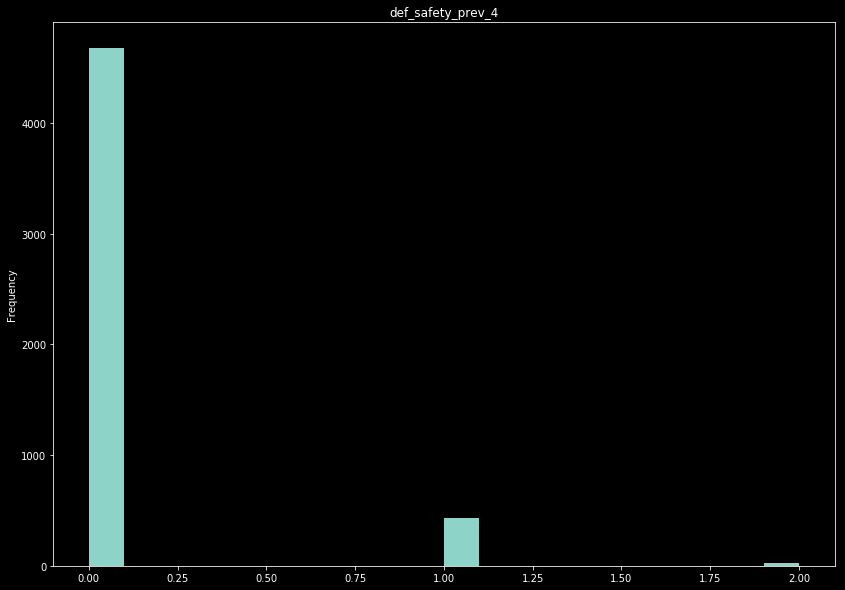

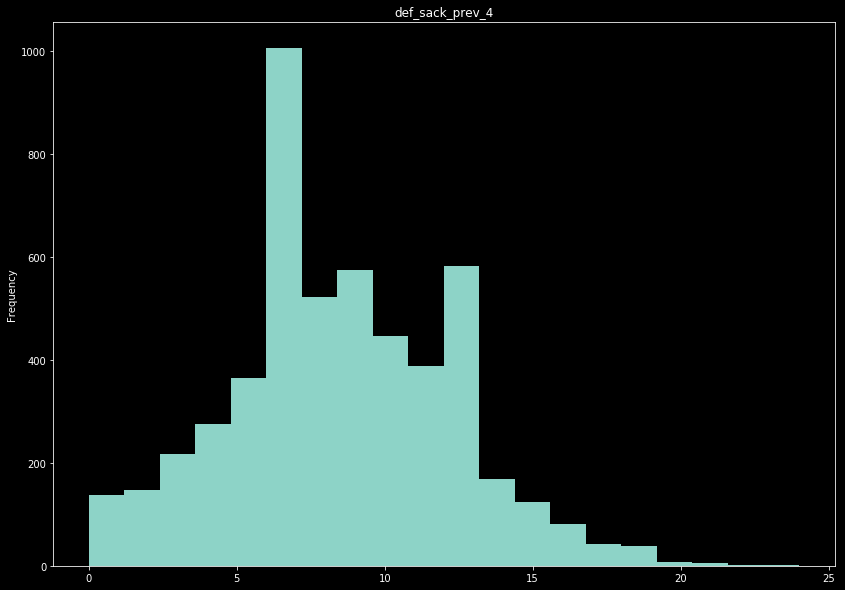

In [34]:
for col in def_df.columns.values[4:]:
    def_df[col].plot.hist(bins=20,title=col)
    plt.show()

Sacks: 1 point.

Interceptions: 2 points.

Fumbles Recovered: 2 points.

Safeties: 2 points.

Defensive Touchdowns: 6 points.

Kick and Punt Return Touchdowns: 6 points.

2-Point Conversion Returns: 2 points.

Points Allowed (0): 10 points

Points Allowed (1-6): 7 points

Points Allowed (7-13): 4 points

Points Allowed (14-20): 1 points

Points Allowed (21-27): 0 points

Points Allowed (28-34): -1 points

Points Allowed (35+): -4 points

In [35]:
def_df.columns

Index([                   u'team',                    u'week',
                          u'year',                u'opp_team',
                           u'tds',                u'rush_yds',
                      u'pass_yds',                 u'fg_made',
                   u'all_def_tds',            u'all_def_turn',
                    u'def_safety',                u'def_sack',
              u'home_flag_prev_4',        u'away_flag_prev_4',
              u'pass_sack_prev_4',   u'allowed_points_prev_4',
          u'allowed_score_prev_4',      u'allowed_tds_prev_4',
       u'allowed_rush_yds_prev_4', u'allowed_pass_yds_prev_4',
        u'allowed_fg_made_prev_4',      u'all_def_tds_prev_4',
           u'all_def_turn_prev_4',       u'def_safety_prev_4',
               u'def_sack_prev_4'],
      dtype='object')

In [29]:
# Off stats are useless? tds, rush_yds, pass_yds, fg_made
# Leave home/away_flags, make a count/discreet continuous

# Target variables are: all_def_tds, all_def_turn, def_safety, def_sack, allowed_points

# Features: 'all_def_tds_prev_4', 'all_def_turn_prev_4', 'def_safety_prev_4', 'def_sack_prev_4', points_allowed_prev_4

In [103]:
# Current 'allowed_' are for the current team, need to turn these into averages for past 4
#  and then average over previous four opponents

n_weeks = 4
wk_str  = str(n_weeks)


other_team_list = ['allowed_tds_prev_4', 'allowed_rush_yds_prev_4', 'allowed_pass_yds_prev_4', 'allowed_fg_made_prev_4']

foo = def_df[ ['team','opp_team','week','year'] ].copy()

foo['opp_avg'+wk_str+'_tds'     ] = def_df['allowed_tds_prev_'     +wk_str]
foo['opp_avg'+wk_str+'_rush_yds'] = def_df['allowed_rush_yds_prev_'+wk_str] 
foo['opp_avg'+wk_str+'_pass_yds'] = def_df['allowed_pass_yds_prev_'+wk_str] 
foo['opp_avg'+wk_str+'_fg_made' ] = def_df['allowed_fg_made_prev_' +wk_str] 

bar =(aps.calc_prev_team_stats( foo, 
                            foo.columns.values[4:], 
                            avg_cols=foo.columns.values[4:] )
                          [
                            [
                                'team',
                                'week',
                                'year',
                                'opp_avg'+wk_str+'_tds_avg_'     +wk_str,
                                'opp_avg'+wk_str+'_rush_yds_avg_'+wk_str,
                                'opp_avg'+wk_str+'_rush_yds_avg_'+wk_str,
                                'opp_avg'+wk_str+'_rush_yds_avg_'+wk_str
                            ]
                          ]
    )                      
#bar.head(20)
#for col in bar.columns.values[:-3]:
#    bar[col] = bar[col] / n_weeks
#    bar[col].plot.hist( bins=20, title=col )
#    plt.show()

In [95]:
bar.loc[(bar['team']=='NYG')&(bar['year']==2009)].head(20)

,team,week,year,opp_avg4_tds_avg_4,opp_avg4_rush_yds_avg_4,opp_avg4_rush_yds_avg_4,opp_avg4_rush_yds_avg_4
81,NYG,-3,2009,11.750000,410.50,410.50,410.50
82,NYG,-2,2009,13.000000,431.00,431.00,431.00
83,NYG,-1,2009,8.000000,285.00,285.00,285.00
84,NYG,0,2009,6.333333,276.00,276.00,276.00
1356,NYG,1,2009,6.250000,305.00,305.00,305.00
1357,NYG,2,2009,5.250000,324.75,324.75,324.75
1358,NYG,3,2009,6.500000,408.50,408.50,408.50
1359,NYG,4,2009,8.500000,457.00,457.00,457.00
1360,NYG,5,2009,9.750000,495.00,495.00,495.00
1361,NYG,6,2009,10.250000,513.00,513.00,513.00


In [9]:
foo.head(20)

,team,opp_team,week,year,opp_tds,opp_rush_yds,opp_pass_yds,opp_fg_made
0,ARI,PIT,-3,2009,NaN,NaN,NaN,NaN
1,ARI,SD,-2,2009,1.0,70.0,281.0,1.0
2,ARI,GB,-1,2009,1.0,134.0,514.0,3.0
3,ARI,DEN,0,2009,6.0,242.0,1013.0,4.0
4,ATL,DET,-3,2009,18.0,469.0,1010.0,6.0
5,ATL,STL,-2,2009,3.0,113.0,115.0,2.0
6,ATL,SD,-1,2009,5.0,275.0,292.0,4.0
7,ATL,BAL,0,2009,8.0,363.0,566.0,6.0
8,BAL,WAS,-3,2009,19.0,608.0,1147.0,7.0
9,BAL,NYJ,-2,2009,2.0,101.0,408.0,3.0


In [14]:
# Need to change foo so that it is current team stats, not the aggregate. Aggregating twice...